# **Credict Card Fraud Detection**

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [38]:
credit_card_data = pd.read_csv('/content/fraudTest.csv',parse_dates=['trans_date_trans_time',])

In [39]:
credit_card_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0.0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0.0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0.0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0.0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0.0


In [40]:
credit_card_data.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [41]:
credit_card_data['hour'] = credit_card_data.trans_date_trans_time.dt.hour

In [42]:
credit_card_data['hourEnc'] = 0
credit_card_data.loc[credit_card_data.hour < 5,'hourEnc'] = 1
credit_card_data.loc[credit_card_data.hour > 21,'hourEnc'] = 1

In [43]:
credit_card_data['trans_date_trans_time'] = pd.to_datetime(credit_card_data['trans_date_trans_time'])

# Sorting the DataFrame based on the transaction time
credit_card_data.sort_values(by='trans_date_trans_time', inplace=True)

# Adding frequencies for last 1, 7, and 30 days
credit_card_data['transactions_last_1d'] = credit_card_data['trans_date_trans_time'].rolling(window=1).count()
credit_card_data['transactions_last_7d'] = credit_card_data['trans_date_trans_time'].rolling(window=7).count()
credit_card_data['transactions_last_30d'] = credit_card_data['trans_date_trans_time'].rolling(window=30).count()

# Filling NaN values with 0 for the initial rows with no history
credit_card_data['transactions_last_1d'].fillna(0, inplace=True)
credit_card_data['transactions_last_7d'].fillna(0, inplace=True)
credit_card_data['transactions_last_30d'].fillna(0, inplace=True)

<ipython-input-43-3b10ffe120c3>:7: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  credit_card_data['transactions_last_1d'] = credit_card_data['trans_date_trans_time'].rolling(window=1).count()
<ipython-input-43-3b10ffe120c3>:8: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  credit_card_data['transactions_last_7d'] = credit_card_data['trans_date_trans_time'].rolling(window=7).count()
<ipython-input-43-3b10ffe120c3>:9: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  credit_card_data['transactions_last_30d'] = credit_card_data['trans_date_trans_time'].rolling(window=30).count()


In [44]:
credit_card_data['trans_date_trans_time'] = pd.to_datetime(credit_card_data['trans_date_trans_time'])

def last1DayTransactionCount(group):
    return group['trans_date_trans_time'].rolling(window=1).count()

def last7DaysTransactionCount(group):
    return group['trans_date_trans_time'].rolling(window=7).count()

def last30DaysTransactionCount(group):
    return group['trans_date_trans_time'].rolling(window=30).count()

# Group by 'cc_num' and apply the custom functions
df1 = credit_card_data.groupby('cc_num').apply(last1DayTransactionCount)
df1 = credit_card_data.groupby('cc_num').apply(last30DaysTransactionCount)

# Resetting the index to obtain a DataFrame
df1 = df1.reset_index(level=0, drop=True)

<ipython-input-44-55eb77247f69>:4: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  return group['trans_date_trans_time'].rolling(window=1).count()
<ipython-input-44-55eb77247f69>:10: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  return group['trans_date_trans_time'].rolling(window=30).count()


In [45]:
credit_card_data['trans_date_trans_time'] = pd.to_datetime(credit_card_data['trans_date_trans_time'])

def last1DayTransactionCount(group):
    return group.resample('1D', on='trans_date_trans_time').size()

def last7DaysTransactionCount(group):
    return group.resample('7D', on='trans_date_trans_time').size()

def last30DaysTransactionCount(group):
    return group.resample('30D', on='trans_date_trans_time').size()

def timeSinceLastTransaction(group):
    return group['trans_date_trans_time'].diff().dt.total_seconds()

# Group by 'cc_num' and apply the custom functions
df1 = credit_card_data.groupby('cc_num').apply(last1DayTransactionCount)
df1 = credit_card_data.groupby('cc_num').apply(last7DaysTransactionCount)
df1 = credit_card_data.groupby('cc_num').apply(last30DaysTransactionCount)
df1['time_diff'] = credit_card_data.groupby('cc_num').apply(timeSinceLastTransaction)

# Resetting the index to obtain a DataFrame
df1 = df1.reset_index(level=0, drop=True)

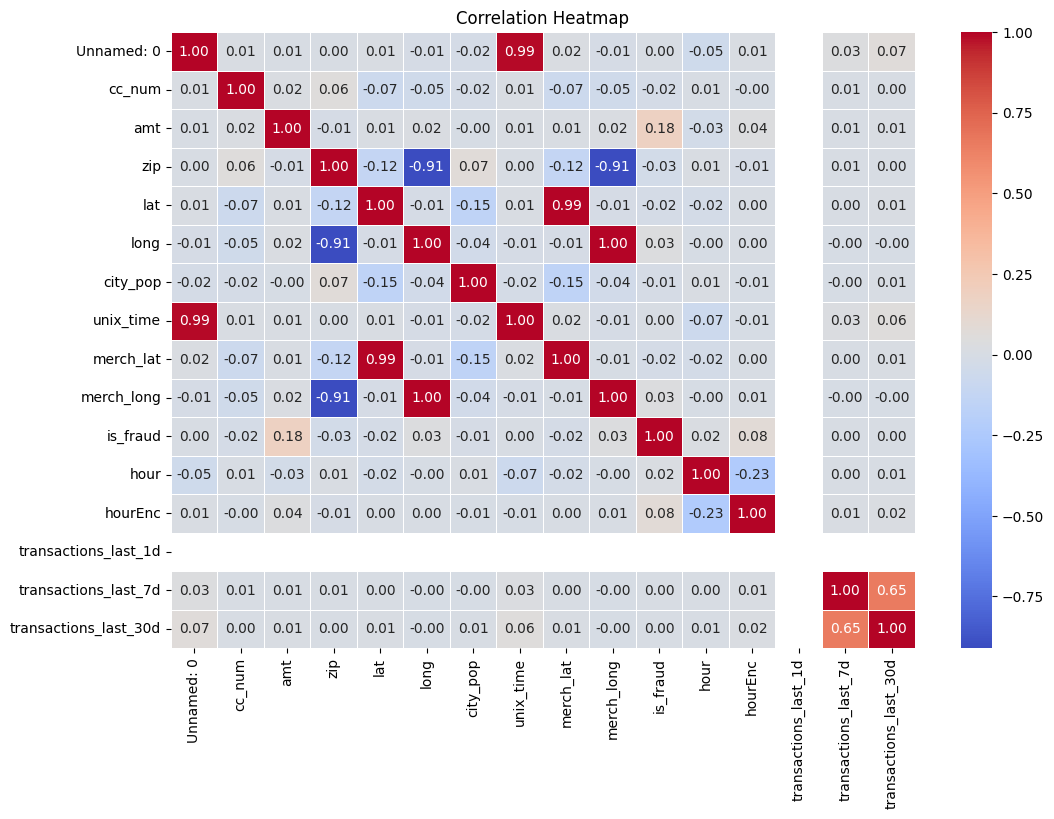

In [46]:
# Drop non-numeric columns
numeric_data = credit_card_data.select_dtypes(include=['number'])

# Calculate correlation matrix
correlation_matrix = numeric_data.corr()

# Plotting a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [47]:
numeric_columns = credit_card_data.select_dtypes(include='number')
fraud_correlation = numeric_columns.corr()['is_fraud'].abs().sort_values(ascending=False)

print(fraud_correlation)

is_fraud                 1.000000
amt                      0.181853
hourEnc                  0.082173
long                     0.033275
merch_long               0.033047
zip                      0.030662
lat                      0.018958
merch_lat                0.018734
cc_num                   0.017394
hour                     0.016208
city_pop                 0.009001
unix_time                0.002584
transactions_last_30d    0.002074
Unnamed: 0               0.001071
transactions_last_7d     0.000970
transactions_last_1d          NaN
Name: is_fraud, dtype: float64


In [48]:
from sklearn.impute import SimpleImputer

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# Scale the imputed data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

# Continue with model training and evaluation


In [49]:
import pandas as pd

# Load datasets
test_data = pd.read_csv('/content/fraudTest.csv')
train_data = pd.read_csv('/content/fraudTrain.csv')

# Impute missing values in test_data and train_data with mean
test_data.fillna(test_data.mean(), inplace=True)
train_data.fillna(train_data.mean(), inplace=True)


<ipython-input-49-9a7719cd4b88>:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_data.fillna(test_data.mean(), inplace=True)
<ipython-input-49-9a7719cd4b88>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_data.fillna(train_data.mean(), inplace=True)


In [50]:
# Check for missing values in the original datasets
print("Missing values in train_data:")
print(train_data.isnull().sum())

print("Missing values in test_data:")
print(test_data.isnull().sum())

# Check for missing values after imputation
# Assuming you've already applied imputation to train_data and test_data

# Preprocess the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check for missing values after scaling
print("Missing values in X_train_scaled:")
print(np.isnan(X_train_scaled).sum())

print("Missing values in X_test_scaled:")
print(np.isnan(X_test_scaled).sum())


Missing values in train_data:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      1
dob                      1
trans_num                1
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64
Missing values in test_data:
Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state     

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load train and test datasets
test_data = pd.read_csv('/content/fraudTest.csv')
train_data = pd.read_csv('/content/fraudTrain.csv')

# Drop rows with missing values
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# Drop non-numeric and non-binary columns for simplicity
numeric_columns_train = train_data.select_dtypes(include='number')
numeric_columns_test = test_data.select_dtypes(include='number')

X_train = numeric_columns_train.drop(['is_fraud'], axis=1)
y_train = train_data['is_fraud']

X_test = numeric_columns_test.drop(['is_fraud'], axis=1)
y_test = test_data['is_fraud']

# Preprocess the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build and train the Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")


Accuracy: 0.0030164944483666
Confusion Matrix:
[[    0 15534]
 [    0    47]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     15534
         1.0       0.00      1.00      0.01        47

    accuracy                           0.00     15581
   macro avg       0.00      0.50      0.00     15581
weighted avg       0.00      0.00      0.00     15581



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
